In [1]:
import time
import random
import numpy as np
import shutil
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
from PIL import Image
from tensorflow.keras import backend, layers, metrics, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import AutoModelForImageClassification
import os
import pandas as pd

tf.__version__, np.__version__

('2.6.2', '1.20.3')

In [2]:
def get_encoder(input_shape):
    """ Returns the image encoding model """
    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [3]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor_Input (InputLayer)       [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Positive_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Negative_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Encode_Model (Sequential)       (None, 256)          22043944    Anchor_Input[0][0]               
                   

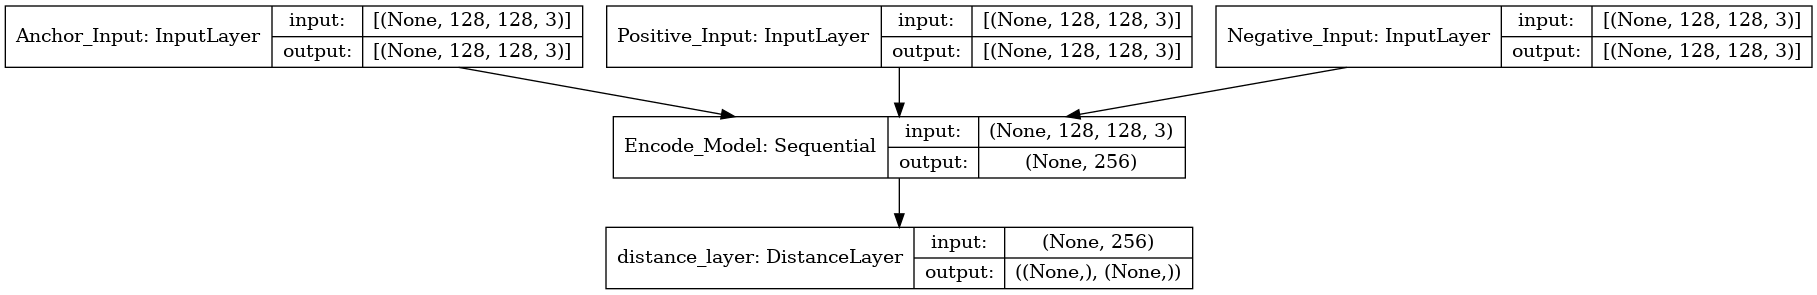

In [4]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [5]:
loaded_model = load_model('/kaggle/input/siamesenetwork_cv/other/default/1/full_siamese_model.h5', custom_objects={'DistanceLayer': DistanceLayer})

In [6]:
loaded_model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor_Input (InputLayer)       [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Negative_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Positive_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Encode_Model (Sequential)       (None, 256)          22043944    Anchor_Input[0][0]               
                                                                 Positive_Input[0][0

# Part A

## Classfication

In [7]:
# Parameters
image_size = (224, 224)  # MobileNet input size
test_dir = '/kaggle/input/cv25-project-dataset/Project Data/Project Data/Val/images'
final_model = "/kaggle/input/mobilenet-cv-2/other/default/1/mobilenet_custom_model (1).h5"

# Function to load test data
def load_data(data_dir, image_size=(224, 224)):
    images = []
    labels = []
    
    for label in sorted(os.listdir(data_dir)):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            main_label = label.split("___")[0]
            
            for img_name in sorted(os.listdir(class_dir)):
                if img_name.startswith('.') or not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                img_path = os.path.join(class_dir, img_name)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(image_size)
                    images.append(np.array(img))
                    labels.append(main_label)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels)

# Load test data
test_images, test_labels = load_data(test_dir)
print(f"Number of images loaded: {len(test_images)}")

# Check if any images were loaded
if len(test_images) == 0:
    print("No images were loaded. Check the directory and try again.")
    exit()

# Normalize images
test_images = test_images / 255.0

# Encode labels
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)

# Retrieve mappings
id2label = {idx: label for idx, label in enumerate(label_encoder.classes_)}
label2id = {label: idx for idx, label in id2label.items()}


model = load_model(final_model)

# Predict on test data
predictions = model.predict(test_images, batch_size=64)

# Get class predictions
predicted_classes = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_labels_encoded, predicted_classes)
print(f"Accuracy: {accuracy:.2f}")

# Decode class indices to labels
predicted_labels = [id2label[class_id] for class_id in predicted_classes]

Number of images loaded: 330
Accuracy: 0.96


In [8]:
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 5, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3,
       3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 4, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 5,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

## Recognition

In [9]:
def classify_image(image, image_label, image_list, image_labels, neg_image, threshold=2):
    distances = []
    
    image = np.expand_dims(image, axis=0)  # Adds a batch dimension
    neg_image = np.expand_dims(neg_image, axis=0)

    # Loop through support images and convert them to tensors
    for supp in image_list:
        supp = np.expand_dims(supp, axis=0)  # Adds a batch dimension to the support image
        dist = loaded_model([image, supp, neg_image])
        dist_pos = dist[0][0].numpy().item()  # First distance (positive)
        
        distances.append(dist_pos)

    min_distance_index = np.argmin(distances)
    min_distance = distances[min_distance_index]
    
    print(image_labels[min_distance_index])
    print(image_label)
    print("****************************")
    
    if min_distance <= threshold:
        closest_label = str(image_labels[min_distance_index])
        return 0 if closest_label == str(image_label) else 1
    else:
        return 1
    
def support_set(class_dir, image_size=(128, 128)):
    images = []
    labels = []

    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        
        if os.path.isfile(image_path):
            try:
                # Load and preprocess the image
                img = Image.open(image_path).convert("RGB")
                img = img.resize(image_size)
                images.append(np.array(img))  # Append image as NumPy array
                label = os.path.splitext(image_file)[0]
                labels.append(label)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
    
    return images, labels

def recog_images(root_dir, mapping_file, image_size=(128, 128)):
    # Load the folder-to-number mapping
    mapping_df = pd.read_csv(mapping_file)
    folder_to_number = dict(zip(mapping_df["Folder Name"], mapping_df["Assigned Number"]))
    
    # Initialize lists to store images and labels
    images = []
    labels = []

    # Iterate through each folder in sorted order
    for folder in sorted(os.listdir(root_dir)):
        folder_path = os.path.join(root_dir, folder)
        
        # Check if it is a directory and exists in the mapping
        if os.path.isdir(folder_path) and folder in folder_to_number:
            # Get the assigned number for the folder
            folder_number = folder_to_number[folder]
            
            # Process each image in sorted order
            for image_file in sorted(os.listdir(folder_path)):
                image_path = os.path.join(folder_path, image_file)
                
                # Check if the item is a file (image)
                if os.path.isfile(image_path):
                    try:
                        # Load the image and resize
                        img = Image.open(image_path).convert("RGB")
                        img = img.resize(image_size)
                        img_array = np.array(img)
                        
                        # Append the image and corresponding label
                        images.append(img_array)
                        labels.append(folder_number)
                    except Exception as e:
                        print(f"Error processing {image_path}: {e}")
    
    return images, labels

# Main logic to process recognition
support_set_base_path ="/kaggle/input/support-set/Support Set"
root_dir = "/kaggle/input/cv25-project-dataset/Project Data/Project Data/Val/images"
mapping_file = "/kaggle/input/mapping-labels/folder_to_number_mapping_test.csv"

recg_images, recg_labels = recog_images(root_dir, mapping_file)

pred_recognition = []

for idx, prediction in enumerate(predicted_classes):
    support_set_path = os.path.join(support_set_base_path, str(prediction))
    support_images, support_labels = support_set(support_set_path, image_size=(128, 128))

    test_image = recg_images[idx]
    test_label = recg_labels[idx]
    #print(test_label)

    for other_prediction in predicted_classes:
        if other_prediction != prediction:
            negative_support_set_path = os.path.join(support_set_base_path, str(other_prediction))
            neg_images, neg_labels = support_set(negative_support_set_path, image_size=(128, 128))

            rand_idx = random.randint(0, len(neg_images) - 1)
            negative_support_images = neg_images[rand_idx]

    result = classify_image(test_image, test_label, support_images, support_labels, negative_support_images)
    print(result)
    print("############################")
    pred_recognition.append(result)

true_recognition=np.array([0]*len(predicted_classes))
print(f"\nAccuracy of model: {accuracy_score(true_recognition, pred_recognition)}\n")

23
10
****************************
1
############################
10
10
****************************
0
############################
10
10
****************************
0
############################
16
10
****************************
1
############################
16
10
****************************
1
############################


KeyboardInterrupt: 

# Part B

Minimum distance: 0.07279038429260254


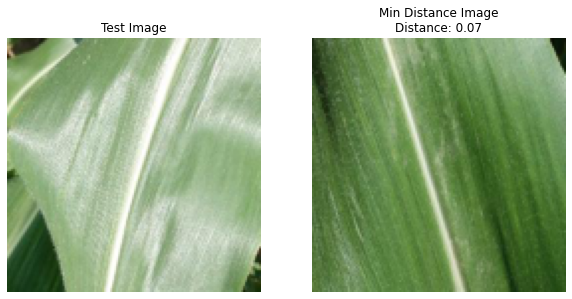

Result: Similar


In [11]:
# Create a placeholder 'null' image
def get_null_image(image_size=(128, 128)):
    return np.zeros((1, image_size[0], image_size[1], 3), dtype=np.float32)  # Add batch dimension

def classify_image(image, image_list, threshold=1.3):
    distances = []
    null_image = get_null_image()  # Null image as placeholder
    
    image = np.expand_dims(image, axis=0)  # Adds a batch dimension
    
    # Loop through support images and convert them to tensors
    for supp in image_list:
        supp = np.expand_dims(supp, axis=0)  # Adds a batch dimension to the support image
        dist = loaded_model([image, supp, null_image])  # Pass null_image for the "neg_image"
        dist_pos = dist[0][0].numpy().item()  # First distance (positive)
        
        distances.append(dist_pos)

    # Find the minimum distance and return class prediction
    min_distance_index = np.argmin(distances)
    min_distance = distances[min_distance_index]
    
    print("Minimum distance:", min_distance)
    
    if min_distance <= threshold:
        result = 0  # Similar
    else:
        result = 1  # Different

    if result == 0:  # Only display images if the result is "Similar"
        # Display images with min distance
        min_distance_image = image_list[min_distance_index]
        
        # Displaying the images
        plt.figure(figsize=(10, 5))

        # Display test image
        plt.subplot(1, 2, 1)
        plt.imshow(image[0])  # Image shape: (1, 128, 128, 3) so we display [0]
        plt.title("Test Image")
        plt.axis('off')

        # Display support image with minimum distance
        plt.subplot(1, 2, 2)
        plt.imshow(min_distance_image)
        plt.title(f"Min Distance Image\nDistance: {min_distance:.2f}")
        plt.axis('off')

        plt.show()
    
    return result

def support_set(class_dir, image_size=(128, 128)):
    images = []

    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        
        if os.path.isfile(image_path):
            try:
                # Load and preprocess the image
                img = Image.open(image_path).convert("RGB")
                img = img.resize(image_size)
                images.append(np.array(img))  # Append image as NumPy array
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
    
    return images

# Example Usage:
root_dir = "/kaggle/input/support-set/Support Set/2"
image_path = "/kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images/Corn_(maize)___healthy/026bd735-b9f4-4eab-86f3-23df15dbec95___R.S_HL 7938 copy.jpg"
image_size = (128, 128)

# Load test image
img = Image.open(image_path).convert("RGB")
img = img.resize(image_size)
img = np.array(img)

# Load support images
support_images = support_set(root_dir, image_size=image_size)

# Classify the image
result = classify_image(img, support_images)
print("Result:", "Similar" if result == 0 else "Different")